In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import PIL
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

2025-11-02 07:56:49.941834: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pip show tensorflow

Name: tensorflow
Version: 2.20.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/damian/projects/tf_env/lib/python3.12/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google_pasta, grpcio, h5py, keras, libclang, ml_dtypes, numpy, opt_einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing_extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
tf.keras.utils.set_random_seed(42)

# Loading Data and EDA

In [4]:
import pathlib

# Create a Path object for the main data directory
data_dir = pathlib.Path('data')

# Find all filepaths ending in .jpg within any subdirectory
all_filepaths = list(data_dir.glob('*/*.jpg'))

# Convert the list of Path objects into a list of plain strings (needed for some libraries)
all_filepaths = [str(p) for p in all_filepaths]

# Get class names by listing subdirectories in 'data'
class_names = sorted([
    item.name for item in data_dir.glob('*') 
    # This ignores hidden folders (like .ipynb_checkpoints in Jupyter)
    if item.is_dir() and not item.name.startswith('.') 
])

print("Class Names:", class_names) 

# Create a dictionary to map class names (strings) to numeric IDs (integers)
class_to_id = {name: i for i, name in enumerate(class_names)} 

# Create a list of all labels (as numbers)
# For every filepath, get its parent's folder name (which is the class name),
# then use the class_to_id dictionary to find its numeric ID.
all_labels = [class_to_id[pathlib.Path(p).parent.name] for p in all_filepaths] 


all_filepaths = np.array(all_filepaths)
all_labels = np.array(all_labels) 

print(f"Total images found: {len(all_filepaths)}")
print(f"Total labels found: {len(all_labels)}") 

IMG_SIZE = (160, 160) 

def load_and_preprocess_image(filepath, label):
    # Read the raw file data from the path
    image = tf.io.read_file(filepath)
    # Decode the raw data into an image tensor (3 channels = RGB)
    image = tf.io.decode_jpeg(image, channels=3)
    # Resize the image to the target dimensions
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    return image, label

Class Names: ['anchor', 'balloon', 'bicycle', 'envelope', 'paper_boat', 'peace_symbol', 'smiley', 'speech_bubble', 'spiral', 'thumb']
Total images found: 431
Total labels found: 431


<Axes: ylabel='count'>

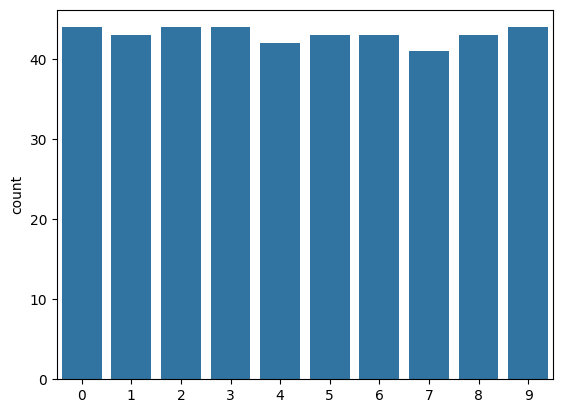

In [5]:
sns.countplot(x=all_labels)

Since there doesn't seem to be a big disparity between classes, sparse_categorical_crossentropy and sparse_categorical_accuracy will be good metrics for training. The confusion matrix can then be used afterward to verify the results and check for any weird anomalies.

Only 431 images is a very small dataset to train a classification model. Taking even 20% for validation might result in the model missing some important images. That's why k-fold cross-validation is preferred. This allows the model to be trained and validated on all of the data, and finally, to train a single model on 100% of the data for the final best-case result. Also, using data augmentation is almost necessary to expand the training dataset.

# Display some images

I0000 00:00:1762066616.707933    2129 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


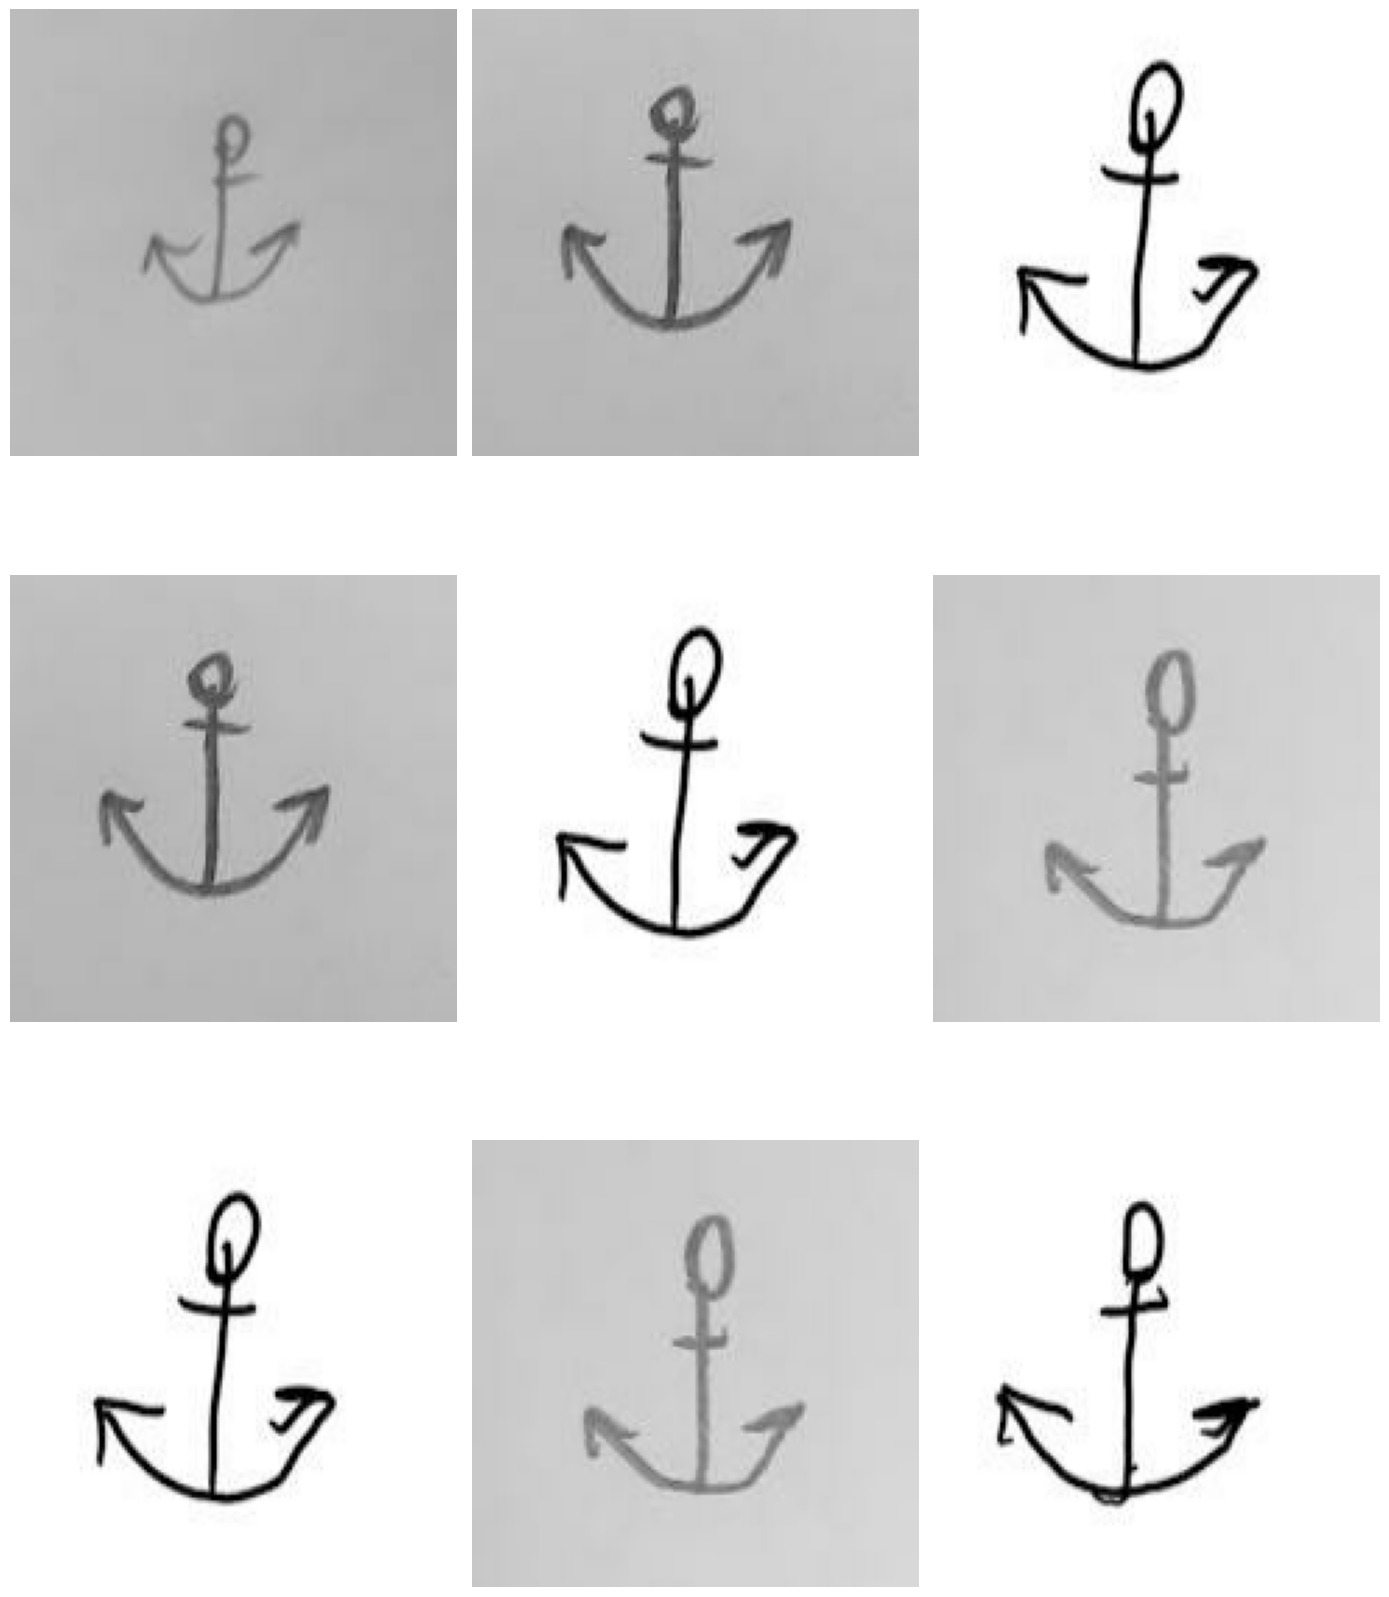

In [6]:
#plot accuracy and loss 
fig, axes = plt.subplots(3, 3, figsize=(14, 18))

for i in range(3):
    for j in range (3):
        img, lbl = load_and_preprocess_image(all_filepaths[i+j], None)
        axes[i, j].imshow(img.numpy().astype("uint8"))
        axes[i, j].axis("off")

plt.tight_layout() 
plt.show()

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = (160, 160)
NUM_CLASSES = len(class_names) 

#Augment data to "expand" the dataset 
data_augmentation = keras.Sequential([
    layers.RandomContrast(factor=0.1),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), 
    layers.RandomRotation(0.1),
    layers.RandomZoom(height_factor=(-0.1, 0.05),width_factor=(-0.1,0.05)),
], name='data_augmentation')



# Display augmented images

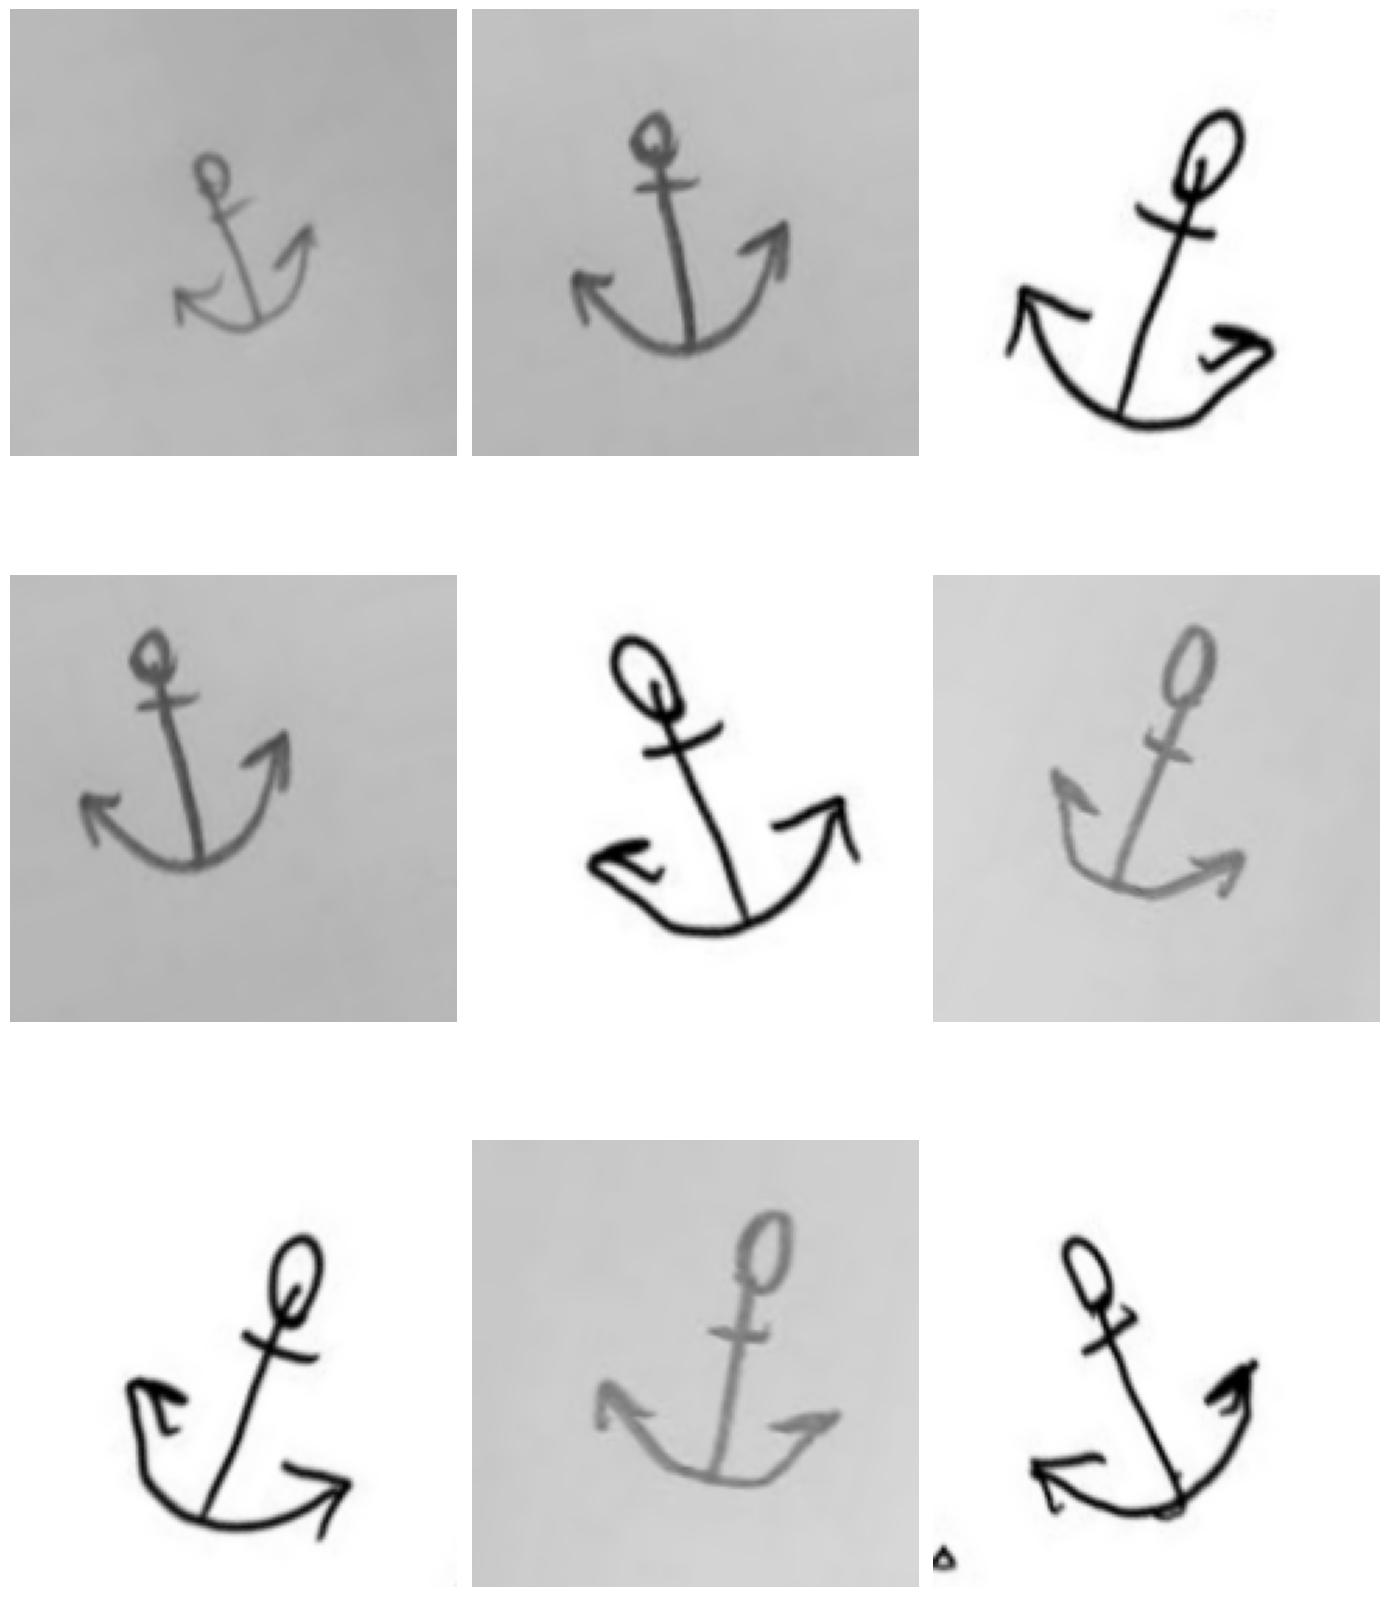

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(14, 18))

for i in range(3):
    for j in range (3):
        #Load the single image (shape is likely (160, 160, 3))
        img, lbl = load_and_preprocess_image(all_filepaths[i+j], None)
        
        #Add a batch dimension (shape becomes (1, 160, 160, 3))
        img_batch = tf.expand_dims(img, axis=0) 
        
        #Apply augmentation to the batch
        augmented_batch = data_augmentation(img_batch)
        augmented_img = augmented_batch[0]
        
        axes[i, j].imshow(augmented_img.numpy().astype("uint8"))
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

Images look different but are still recognisable, this is exactly what is needed.

My first thought was to use transfer learning, as those tend to perform better on small datasets since they have mastered feature extraction on much larger datasets.

In [9]:
def create_transfer_model():
    base_model = MobileNetV2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,  
        weights='imagenet'  
    )

    base_model.trainable = False

    model = keras.Sequential([

        layers.InputLayer(shape=IMG_SIZE + (3,)),
        data_augmentation,

        #preprocesing so model fits base_model
        layers.Lambda(preprocess_input),

        #transfer model
        base_model,

        #Model head   
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        #decison layer 
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

Even though my transfer learning model (based on Google's MobileNetV2) is performing very well, I've decided to create one completely from scratch. The transfer model had a built-in preprocessing function, but for this new one, I'm just going to scale the data and see if that's sufficient. 

In [10]:
from tensorflow.keras import regularizers
def create_basic_model():
    
    basic_model = keras.Sequential([
        layers.InputLayer(shape=IMG_SIZE + (3,)),
        
        data_augmentation,

        #preprocessing
        layers.Rescaling(1.0 / 255),

        #Feature extraction
        layers.Conv2D(32, 3, strides=2, padding="same", kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPool2D(),     
    
        layers.Conv2D(64, 3, strides=2, padding="same", kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPool2D(), 
    
        layers.SeparableConv2D(128, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(3, padding="same"), 
    
        layers.SeparableConv2D(256, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(3, padding="same"),
    
        layers.SeparableConv2D(256, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(3, padding="same"),
        
        #Model head   
        layers.GlobalAveragePooling2D(),
        layers.Dense(units = 256, activation="relu", kernel_initializer="he_normal"),
        layers.Dropout(0.5),
        layers.Dense(units = 128, activation="relu", kernel_initializer="he_normal"),
        layers.Dropout(0.4),
        layers.Dense(units = 64, activation="relu", kernel_initializer="he_normal"),
        layers.Dropout(0.4),
        
        #decison layer 
        layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    
    basic_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return basic_model

In [11]:
#keras.utils.plot_model(create_basic_model(), show_shapes=True, dpi=50, show_layer_activations=True)

# Train model using k-fold classfication

In [12]:
k = 3 # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# To store the results from each fold
fold_histories = []
stopped_epochs = []
all_true_labels = []
all_pred_labels = []

fold_number = 1

In [13]:
for train_index, val_index in skf.split(all_filepaths, all_labels):
    print(f"--- Starting Fold {fold_number}/{k} ---")
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=100, #If fewer than 100 for basic_model it may not learn 
        restore_best_weights=True,
        verbose=1
    )
    
    # Get the file paths and labels for the current fold
    train_paths = all_filepaths[train_index]
    train_labels = all_labels[train_index]
    val_paths = all_filepaths[val_index]
    val_labels = all_labels[val_index]

    # --- Create tf.data.Dataset for this fold ---
    # Training dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(buffer_size=len(train_paths)).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE) #Prefetch data (allows for faster model training on gpu)

    # Validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(64).prefetch(buffer_size=tf.data.AUTOTUNE) #Prefetch data (allows for faster model training on gpu)

    
    #UNCOMENT JUST ONE MODEL (THE ONE YOU WANT TO VALIDATE AND LATER TRAIN) 
    model = create_transfer_model()
    #model = create_basic_model()
    
    # Train the model
    history = model.fit(
        train_ds,
        validation_data=(val_ds),
        epochs=2000, 
        batch_size=64,
        callbacks=[early_stopping],
        verbose=1
    )
    
    fold_histories.append(history)

    stopped_epochs.append(len(history.history['val_loss']))
    
    fold_number += 1

    print(f"--- Generating predictions for Fold {fold_number} ---")
    val_pred_probs = model.predict(val_ds)
    val_pred_labels = np.argmax(val_pred_probs, axis=1)
    
    #save predicitions from this fold 
    all_true_labels.extend(val_labels) 
    all_pred_labels.extend(val_pred_labels)


print("\n--- Cross-Validation Complete ---")

val_accuracies = [h.history['sparse_categorical_accuracy'][-1] for h in fold_histories]
avg_val_accuracy = np.mean(val_accuracies)
std_val_accuracy = np.std(val_accuracies)
avg_stopped_epoch = np.mean(stopped_epochs)

print(f"Validation accuracy across {k} folds:")
for i, acc in enumerate(val_accuracies):
    print(f" Fold {i+1}: {acc:.4f} (stopped at epoch {stopped_epochs[i]})")

print(f"\nAverage Validation Accuracy (from history): {avg_val_accuracy:.4f} (+/- {std_val_accuracy:.4f})")
print(f"Average Stopping Epoch: {avg_stopped_epoch:.0f}\n")






--- Starting Fold 1/3 ---
Epoch 1/2000


2025-11-02 07:57:06.951405: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - loss: 2.9387 - sparse_categorical_accuracy: 0.0941 - val_loss: 2.0360 - val_sparse_categorical_accuracy: 0.2917
Epoch 2/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 2.3747 - sparse_categorical_accuracy: 0.1672 - val_loss: 1.8922 - val_sparse_categorical_accuracy: 0.4722
Epoch 3/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.0348 - sparse_categorical_accuracy: 0.2474 - val_loss: 1.7379 - val_sparse_categorical_accuracy: 0.5417
Epoch 4/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.8734 - sparse_categorical_accuracy: 0.2857 - val_loss: 1.5823 - val_sparse_categorical_accuracy: 0.5694
Epoch 5/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.7560 - sparse_categorical_accuracy: 0.3798 - val_loss: 1.4344 - val_sparse_categorical_accuracy: 0.6389
Epoch 6/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.6760 - sparse_categorical_accuracy: 0.4216 - val_loss: 1.2780 - val_sparse_categorical_accuracy: 0.6875
Epoch 7/2000
5/5 ━━━

# Model performance analysis 

In [14]:
print("--- Overall Classification Report (from all fold predictions) ---")
print(classification_report(all_true_labels, all_pred_labels, target_names=class_names))

--- Overall Classification Report (from all fold predictions) ---
               precision    recall  f1-score   support

       anchor       0.98      1.00      0.99        44
      balloon       1.00      0.93      0.96        43
      bicycle       1.00      1.00      1.00        44
     envelope       0.98      1.00      0.99        44
   paper_boat       1.00      0.98      0.99        42
 peace_symbol       1.00      1.00      1.00        43
       smiley       1.00      1.00      1.00        43
speech_bubble       0.91      1.00      0.95        41
       spiral       1.00      1.00      1.00        43
        thumb       1.00      0.95      0.98        44

     accuracy                           0.99       431
    macro avg       0.99      0.99      0.99       431
 weighted avg       0.99      0.99      0.99       431



scores look pretty good for both models 


--- Overall Confusion Matrix ---


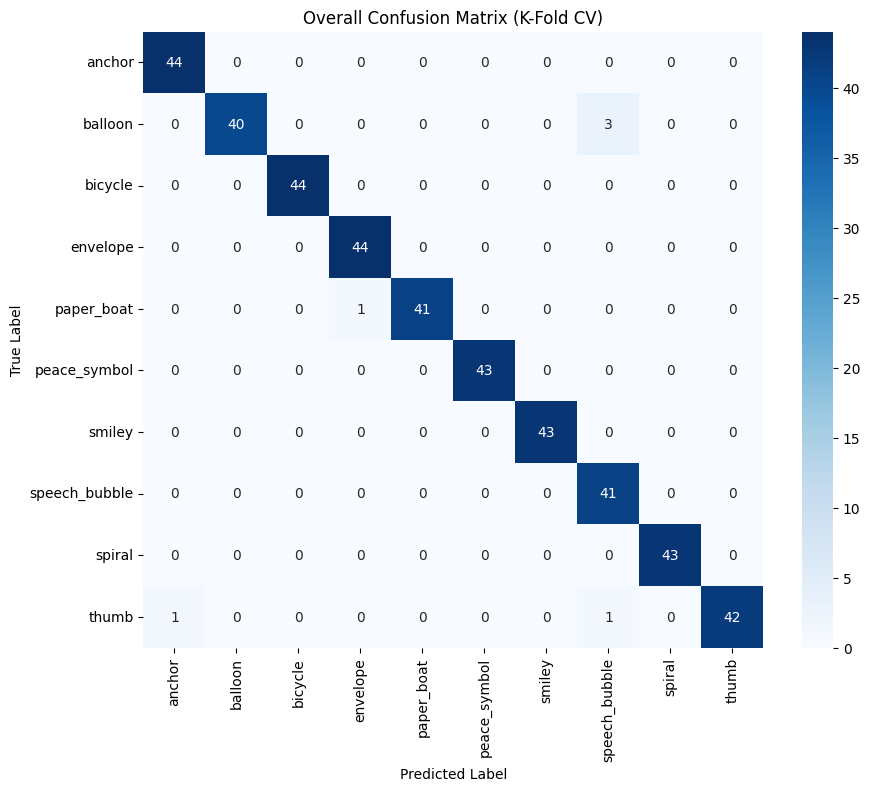

In [15]:
print("\n--- Overall Confusion Matrix ---")
cm = confusion_matrix(all_true_labels, all_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix (K-Fold CV)')
plt.show()

Confusion matrix looks very good for both models, very few mistakes

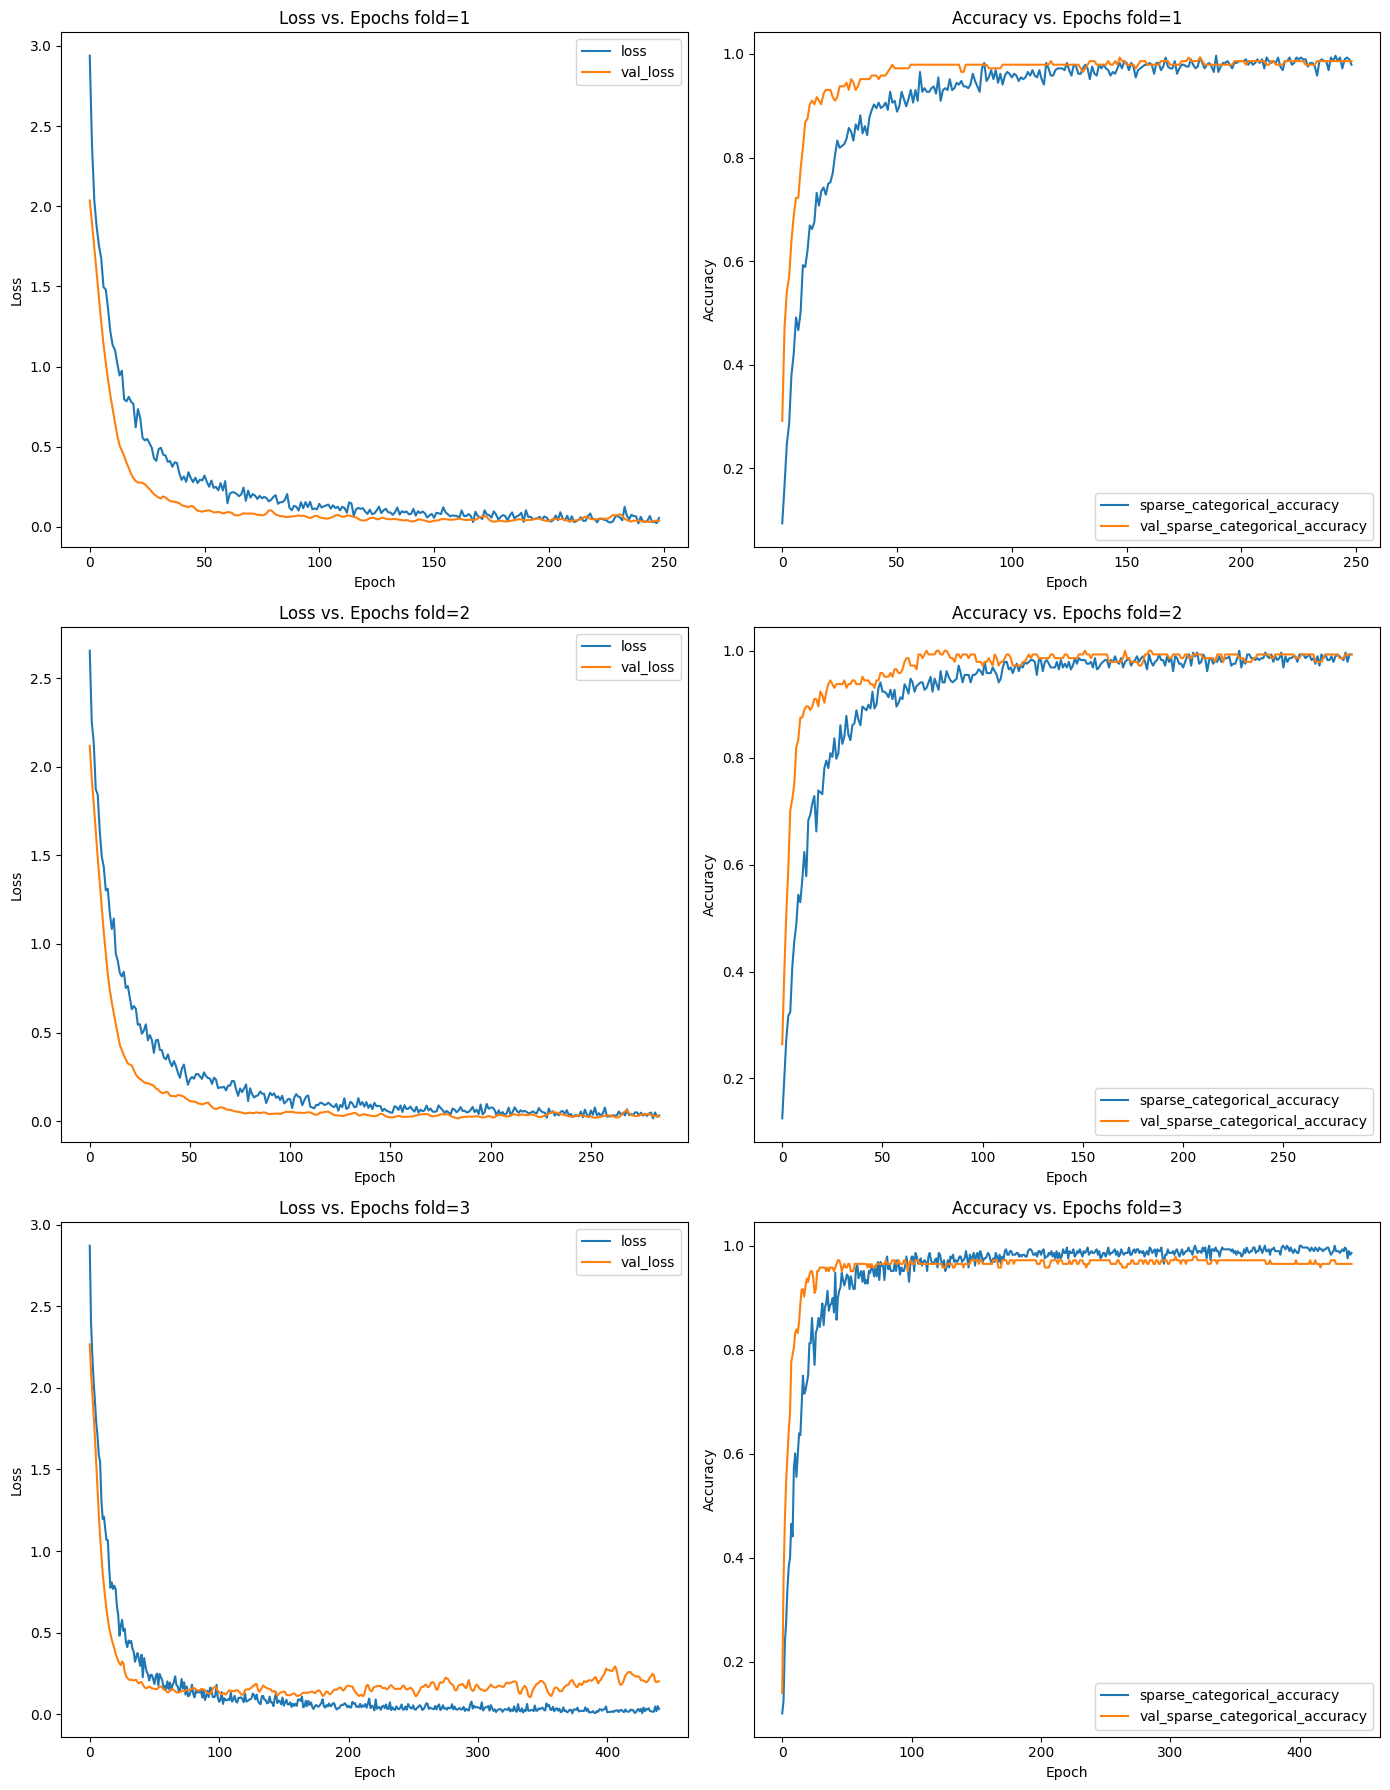

In [16]:
#plot accuracy and loss 
fig, axes = plt.subplots(k, 2, figsize=(14, 6*k))

for i in range(k):
    history_frame = pd.DataFrame(fold_histories[i].history)
    
    history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[i, 0])
    axes[i, 0].set_title(f"Loss vs. Epochs fold={i+1}")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Loss")
    
    history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(ax=axes[i, 1])
    axes[i, 1].set_title(f"Accuracy vs. Epochs fold={i+1}")
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Accuracy")
    

plt.tight_layout() 
plt.show()

Model Conclusions

    Transfer Learning Model: This model performs very well. The loss is low, accuracy is high, and the training and validation curves track each other closely, showing good generalization.

    Scratch-Built Model: This model's performance is unstable. The validation loss and accuracy are volatile, with sharp spikes and dips.

Analysis

    Weaker Feature Extraction: The scratch-built model is likely worse at extracting complex features than the pre-trained transfer learning model.

    Small Validation Set: The instability is amplified by the small validation set. Even a few misclassified images cause a drastic drop in accuracy and a spike in loss.

In [17]:
print(f"Creating final training dataset with {len(all_filepaths)} images...")

# Create the dataset from all data
full_train_ds = tf.data.Dataset.from_tensor_slices((all_filepaths, all_labels))

full_train_ds = full_train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
full_train_ds = full_train_ds.shuffle(buffer_size=len(all_filepaths)).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

Creating final training dataset with 431 images...


In [18]:
avg_stopped_epoch = np.mean(stopped_epochs)
final_epochs = int(np.round(avg_stopped_epoch))

print(f"The average stopping epoch was {avg_stopped_epoch:.2f}.")
print(f"Training the final model for {final_epochs} epochs.")

The average stopping epoch was 325.00.
Training the final model for 325 epochs.


In [19]:
#UNCOMENT JUST ONE MODEL (THE ONE YOU VALIDATED) 
final_model = create_transfer_model()
#final_model = create_basic_model()

# Train it on the full dataset.
history_final = final_model.fit(
    full_train_ds,
    epochs=final_epochs, # Use the calculated average number of epochs
    verbose=1
)

print("\n--- Final Model Training Complete ---")

Epoch 1/325
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 2.6473 - sparse_categorical_accuracy: 0.1230
Epoch 2/325
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2.1549 - sparse_categorical_accuracy: 0.2227
Epoch 3/325
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.9422 - sparse_categorical_accuracy: 0.2993
Epoch 4/325
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.7846 - sparse_categorical_accuracy: 0.3898
Epoch 5/325
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.6112 - sparse_categorical_accuracy: 0.4362
Epoch 6/325
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.4520 - sparse_categorical_accuracy: 0.5035
Epoch 7/325
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.2422 - sparse_categorical_accuracy: 0.5847
Epoch 8/325
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.1880 - sparse_categorical_accuracy: 0.5986
Epoch 9/325
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.0773 - sparse_categorical_accuracy: 0.6288
Epoch 10/325
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.9888 - spars

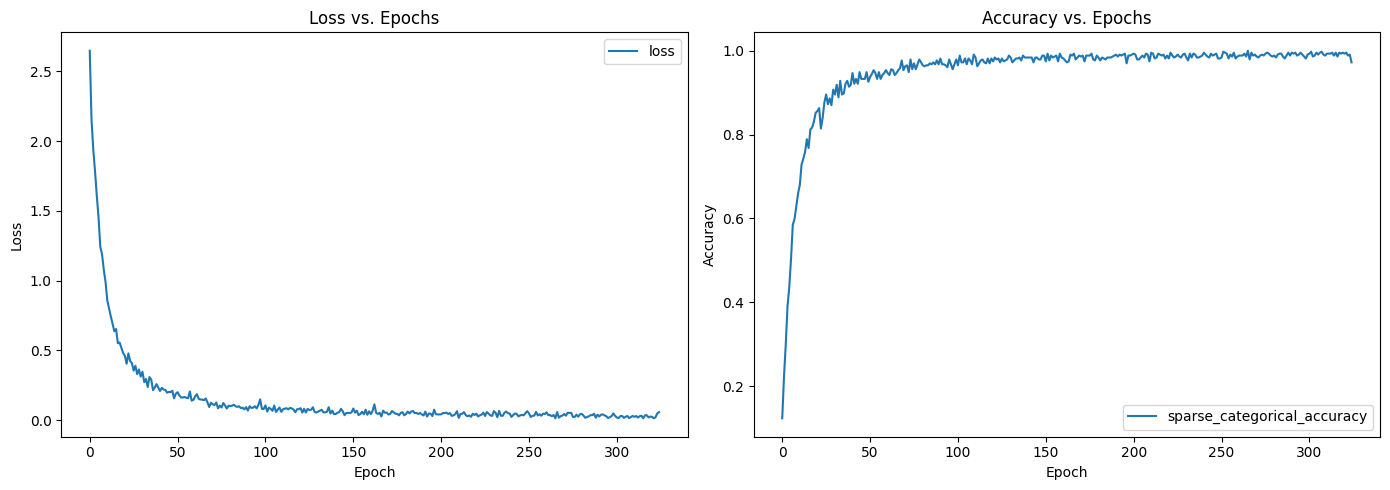

In [20]:
history_frame = pd.DataFrame(history_final.history)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

history_frame.loc[:, ['loss']].plot(ax=axes[0])
axes[0].set_title("Loss vs. Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

history_frame.loc[:, ['sparse_categorical_accuracy']].plot(ax=axes[1])
axes[1].set_title("Accuracy vs. Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")

# Display the entire figure with both plots
plt.tight_layout() 
plt.show()

# Final test: Classify a real, completely new, hand-drawn image of my own.
I often do this with models and consider it a sanity check.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


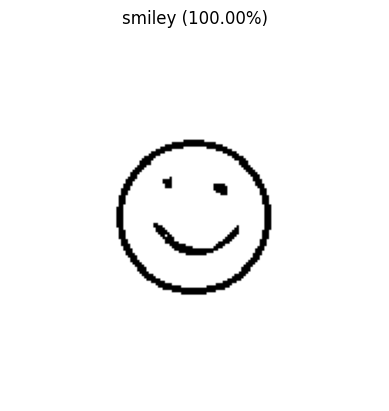

This image is most likely a: smiley
Confidence: 100.00%
Raw prediction scores: [5.2141008e-16 1.2458500e-15 4.7147475e-19 5.2319084e-14 8.8492793e-15
 1.6297911e-17 1.0000000e+00 1.5995850e-14 1.2268029e-13 1.3637252e-20]


In [21]:

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Define the file path for the single image you want to test
image_path = 'sml.png' 

# Load the image from the file using Keras utilities.
img = image.load_img(image_path, target_size=(160, 160))

# Convert the loaded PIL Image object into a NumPy array
img_array = image.img_to_array(img)

# Add a "batch" dimension to the array (models expects batch on input).
img_batch = np.expand_dims(img_array, axis=0)

# get prediction
predictions = final_model.predict(img_batch)

#select highes prediction score
score_index = np.argmax(predictions[0])
predicted_class = class_names[score_index]
confidence = 100 * np.max(predictions[0])

plt.imshow(img)
plt.title(f"{predicted_class} ({confidence:.2f}%)")
plt.axis("off")
plt.show()

print(f"This image is most likely a: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")
print("Raw prediction scores:", predictions[0])

I'm going to say the results are pretty good. The model seems to be quite sure that this is a smiley and the other predictions are very low.

In [22]:
final_model.save('final_model_transfer.keras')
final_model.save_weights('final_model_transfer.weights.h5')

In [23]:
final_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,776,608 (10.59 MB)

 Trainable params: 172,874 (675.29 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 345,750 (1.32 MB)

In [24]:
import sys
!{sys.executable} -m pip freeze > requirements.txt